### Harmonization and annotation of data collections with scVI and scANVI
An important task of single-cell analysis is the integration of several datasets. scVI can be used for this purpose. We also introduce scANVI, an end-to-end framework for transfer of annotations. We also show how to use these frameworks for differential gene expression analysis. Here we demonstrate this functionality with an integrated analysis of two datasets of peripheral blood mononuclear cells publicly available from 10X Genomics. The same pipeline would generally be used to analyze a collection of scRNA-seq datasets.


In [1]:
# If running in Colab, navigate to Runtime -> Change runtime type
# and ensure you're using a Python 3 runtime with GPU hardware accelerator
# installation in Colab can take several minutes

In [2]:
import sys
IN_COLAB = "google.colab" in sys.modules

def allow_notebook_for_test():
    print("Testing the harmonization notebook")

show_plot = True
test_mode = False
save_path = "data/"

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@posterior_refactor#egg=scvi[notebooks]

     |████████████████████████████████| 112kB 5.5MB/s 
     |████████████████████████████████| 122kB 7.3MB/s 
     |████████████████████████████████| 8.7MB 6.9MB/s 
     |████████████████████████████████| 4.3MB 42.4MB/s 
     |████████████████████████████████| 2.2MB 50.5MB/s 
     |████████████████████████████████| 2.4MB 49.3MB/s 
     |████████████████████████████████| 3.2MB 53.3MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 7.7MB 29.8MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 


In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc

import scvi

from umap import UMAP

if IN_COLAB:
    %matplotlib inline

# Use GPU
use_cuda = True

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


For this manuscript, we focus on the use case presented in the [BBKNN repository](https://github.com/Teichlab/bbknn). Indeed, they provide a preprocessed AnnData file, which makes it handy for presentation of our method. To run these methods on your own data, simply follow the excellent tutorials from [scanpy](https://scanpy.readthedocs.io/en/stable/tutorials.html).

This dataset has around fifteen thousands peripheral blood mononuclear cells with two experimental assays (3' and 5').

In [4]:
adata = sc.read('data/PBMC.merged.h5ad', backup_url='ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/PBMC.merged.h5ad')

/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


Because these datasets are normalized, we need to undo the normalization to make sure that our algorithms receive the counts. scVI or scANVI is designed to handle sequencing depth and need not cell-wise normalization. The only particular case in which *gene* normalization may help is when integrating 10x and SS2 data. In this setting, we have found that normalizing, e.g., by gene length greatly improved harmonization performance.

In [5]:
temp = adata.raw
temp = sc.AnnData(np.expm1(temp.X), var=adata.raw.var, obs=adata.obs)
adata = temp[:, adata.var_names].copy()

Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate for large gene sets in terms of runtime, we usually recommend filtering genes for best performance when the dataset has few number of cells. As a rule of thumb, performance starts to decrease when number of cells and number of genes are comparable. This point is emphasized in this [comparative analysis](https://doi.org/10.1101/2020.05.22.111161) of data integration algorithms for scRNA-seq data.

In this case, the data is already filtered, so we needn't worry about it.

In [6]:
adata.obs.Sample.value_counts()

data_3p    8098
data_5p    7378
Name: Sample, dtype: int64

### Harmonization with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:
+ register the AnnData object with the correct key to identify the sample,
+ create a SCVI object and connect it to the AnnData.

In [7]:
scvi.dataset.setup_anndata(adata, batch_key="batch")

[2020-08-19 02:02:09,526] INFO - scvi.dataset._anndata | Using batches from adata.obs["batch"]
[2020-08-19 02:02:09,529] INFO - scvi.dataset._anndata | No label_key inputted, assuming all cells have same label
[2020-08-19 02:02:09,531] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-08-19 02:02:09,562] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-08-19 02:02:09,716] INFO - scvi.dataset._anndata | Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
[2020-08-19 02:02:09,719] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 15476 cells, 1199 genes, 2 batches, and 0 proteins.


/usr/local/lib/python3.6/dist-packages/scvi/dataset/_anndata.py:436: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc


In [8]:
vae = scvi.models.SCVI(adata, use_cuda=True)

Now we train scVI by calling vae.train(). This should take a couple of minutes on a Colab session

In [9]:
vae.train(n_epochs=100)

[2020-08-19 02:02:20,118] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-19 02:02:20,149] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-19 02:02:20,176] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-19 02:02:20,178] INFO - scvi.core.trainers.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-08-19 02:02:20,178] INFO - scvi.core.trainers.inference | KL warmup for 400 epochs
training:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/scvi/core/_distributions.py:222: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


training: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]
[2020-08-19 02:04:05,541] INFO - scvi.core.trainers.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [10]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

[2020-08-19 02:04:05,579] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.


Finally, we can cluster the dataset and visualize it with UMAP

In [11]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

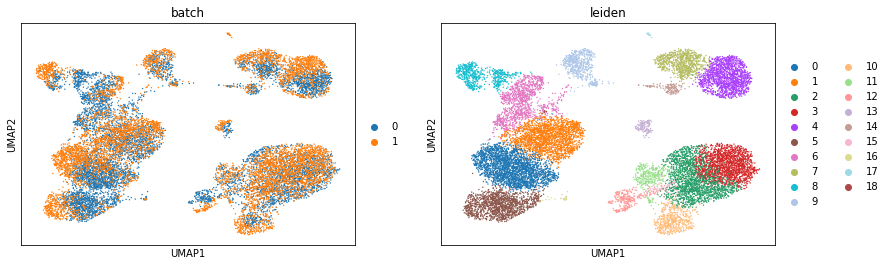

In [12]:
sc.pl.umap(adata, color=['batch', 'leiden'])

Because this combination of datasets is used for benchmarking purposes, we have access here to curated annotations. We can use those to assess whether the harmonization worked reasonably well. 

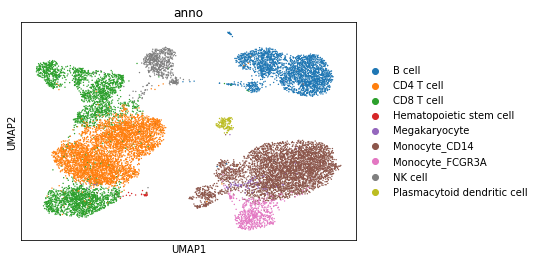

In [13]:
sc.pl.umap(adata, color=['anno'])

From a quick glance, it looks like the harmonization worked well. Indeed, the two datasets are relatively mixed in latent space and the cell type are preserved. A more refined analysis may be done at the level of markers, we refer to the BBKNN notebook for further details

### Transfer of Annotations with scANVI

We now investigate a different although complementary problem. Previously, we used scVI as we assumed we did not have any cell type annotation available to guide us. Consequently, one would need to use marker genes in order to annotate the clusters from the previous analysis. 

Now, we assume that one dataset plays the role of the reference data, with known labels, and one is the query. We will use scANVI to transfer our cell type knowledge from the reference to the query data. For this, we simply need to indicate to indicate to scANVI:
+ the sample identifier for each cell (as in scVI)
+ the cell type, or an unnassigned label for each cell

We quickly simulate some missing cell type annotation by adding an altered scanpy obs entry with "unknown" cell types for the 5' data

In [ ]:
scanvi_celltype = np.asarray(adata.obs.anno)
scanvi_celltype[adata.obs["batch"] == "1"] = "Unknown"
adata.obs["celltype_scanvi"] = scanvi_celltype

Now we may register the AnnData object and run scANVI

In [ ]:
scvi.dataset.setup_anndata(adata, batch_key="batch", labels_key="celltype_scanvi")

[2020-08-18 23:23:30,923] INFO - scvi.dataset._anndata | Using batches from adata.obs["batch"]
[2020-08-18 23:23:30,927] INFO - scvi.dataset._anndata | Using labels from adata.obs["celltype_scanvi"]
[2020-08-18 23:23:30,935] INFO - scvi.dataset._anndata | Using data from adata.X
[2020-08-18 23:23:30,965] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-08-18 23:23:30,987] INFO - scvi.dataset._anndata | Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
[2020-08-18 23:23:30,989] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 15476 cells, 1199 genes, 2 batches, and 0 proteins.


/usr/local/lib/python3.6/dist-packages/scvi/dataset/_anndata.py:436: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc


In [ ]:
lvae = scvi.models.SCANVI(adata, "Unknown", use_cuda=True, n_)

In [ ]:
lvae.train(n_epochs_unsupervised=100)

[2020-08-18 23:23:38,396] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-18 23:23:38,423] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-18 23:23:38,447] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-18 23:23:38,448] INFO - scvi.core.trainers.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-08-18 23:23:38,449] INFO - scvi.core.trainers.inference | KL warmup for 400 epochs
training:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/scvi/core/_distributions.py:222: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


training: 100%|██████████| 100/100 [01:50<00:00,  1.11s/it]
[2020-08-18 23:25:28,986] INFO - scvi.core.trainers.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-08-18 23:25:29,043] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-18 23:25:29,070] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-18 23:25:29,098] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-18 23:25:29,129] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-18 23:25:29,155] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-18 23:25:2

Now we can predict the missing cell types, and get the latent space

In [ ]:
adata.obs["C_scANVI"] = lvae.predict(adata)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

[2020-08-18 23:26:00,581] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.
[2020-08-18 23:26:00,873] WARNING - scvi.dataset._biodataset | Make sure the registered X field in anndata contains unnormalized count data.


Again, we may visualize the latent space as well as the inferred labels

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

... storing 'celltype_scanvi' as categorical
... storing 'C_scANVI' as categorical


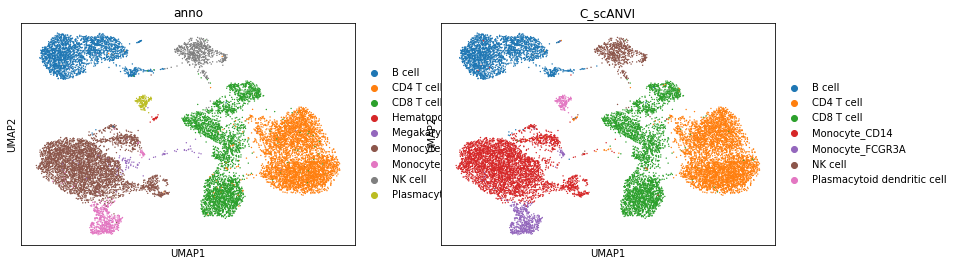

In [ ]:
sc.pl.umap(adata, color=['anno', 'C_scANVI'])

As we see in this, scANVI's latent space separates all cell types well. While it performs well at classifying major cell types, that are well represented in the labelled set, it however struggles with rare cell types. To mitigate this known effect, it is possible to perform manual curation of the transfered labels for those rare cell types. We also expect some ad-hoc strategies, such as subsampling the amount of labelled cells to be equally balanced among cell types, to improve these results. 

Ready to learn more? Dig into our [documentation](https://scvi.readthedocs.io/en/stable/)!